# Down-scaled multi-area model

![Model overview](model_construction.png)

The code in this notebook implements the down-scaled version of spiking network model of macaque visual cortex developed at the Institute of Neuroscience and Medicine (INM-6), Research Center Jülich. The full-scale model has been documented in the following publications:

1. Schmidt M, Bakker R, Hilgetag CC, Diesmann M & van Albada SJ
   Multi-scale account of the network structure of macaque visual cortex
   Brain Structure and Function (2018), 223: 1409 [https://doi.org/10.1007/s00429-017-1554-4](https://doi.org/10.1007/s00429-017-1554-4)

2. Schuecker J, Schmidt M, van Albada SJ, Diesmann M & Helias M (2017)
   Fundamental Activity Constraints Lead to Specific Interpretations of the Connectome.
   PLOS Computational Biology, 13(2): e1005179. [https://doi.org/10.1371/journal.pcbi.1005179](https://doi.org/10.1371/journal.pcbi.1005179)

3. Schmidt M, Bakker R, Shen K, Bezgin B, Diesmann M & van Albada SJ (2018)
   A multi-scale layer-resolved spiking network model of
   resting-state dynamics in macaque cortex. PLOS Computational Biology, 14(9): e1006359. [https://doi.org/10.1371/journal.pcbi.1006359](https://doi.org/10.1371/journal.pcbi.1006359)
<br>

#### Notebook structure <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Parameterization](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
    * [1.2. Default parameters](#section_1_2)
* [S2. Multi-Area Model Instantiation and Simulation](#section_2)
    * [2.1. Instantiate a multi-area model](#section_2_1)
    * [2.2. Predict firing rates from theory](#section_2_2)
    * [2.3. Extract and visualize interareal connectivity](#section_2_3)
    * [2.4. Run a simulation](#section_2_4)
* [S3. Simulation Results Visualization](#section_3) 
    * [3.1. Instantaneous and mean firing rate across all populations](#section_3_1)
    * [3.2. Resting state plots](#section_3_2)
    * [3.3. Time-averaged population rates](#section_3_3)

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [2]:
%matplotlib inline
import numpy as np
import os
import nest
import json
import sys
from IPython.display import display, HTML

from multiarea_model import MultiAreaModel
from multiarea_model import Analysis
from config import base_path, data_path

sys.path.append('./figures/MAM2EBRAINS')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5
 Built: Jul 12 2023 06:25:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
%%capture captured
!pip install nested_dict dicthash

In [4]:
# Jupyter notebook display format setting
style = """
<style>
table {float:left}
</style>
"""
display(HTML(style))

Go back to [Notebook structure](#toc)

## S1. Parameterization <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

|Parameter|Default value|Value range/options|Value assigned|Description|
|:-------:|:-----------:|:-----------------:|:------------:|:---------:|
|scale_down_to|1.       |(0, 1.0]           |0.005         |$^1$       |
|cc_weights_factor|1.   |[1.0, 2.5]         |1.            |$^2$       |
|areas_simulated|complete_area_list|Sublists of complete_area_list|complete_area_list|$^3$|
|replace_non_simulated_areas|None|None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'|'het_poisson_stat'|$^4$ |

1. `scale_down_to` <br>
scale_down_to is the down-scaling factor which defines the the ratio of the full scale multi-area model being down-scaled to a model with fewer neurons and indegrees so as to be simulated on machines with lower computational ability and the simulation results can be obtained within relative shorter period of time. <br> Its deafualt value if `1.` meaning full scale simulation. <br> In the pre-set downscale version, it's set as `0.005`, where the numer of neurons and indegrees are both scaled down to 0.5% of its full scale amount, where the model can usually be simulated on a local machine. <br> **Warning**: This will not yield reasonable dynamical results from the network and is only meant to demonstrate the simulation workflow <br> 
2. `cc_weights_factor` <br>
This scaling factor controls the cortico-cortical synaptic strength. <br> By default it's set as `1.0`, where the inter-area synaptic strength is the same as the intra-areal. <br> **Important**: This factor changes the network activity from ground state to metastable state. <br>
3. `areas_simulated` <br>
This parameter specifies the cortical areas included in the simulation process. Its default value is `complete_area_list` meaning all the areas in the complete_area_list will be actually simulated. <br>
complete_area_list = `['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']` <br>
The value assigned to simulation_areas can be any sublist of the compete_area_list specifying areas a user want to include in his/her simulation. <br>
4. `replace_non_simulated_areas` <br>
The paramter replace_non_simulated_areas defines how non-simulated areas will be replaced. <br> It's set as `None` by default when the parameter areas_simulated is set as full_area_list where all areas will be simulated so that no areas need to be replaced. <br> Other options are: `'hom_poisson_stat'`, `'het_poisson_stat'`, and `'het_current_nonstat'`. `'hom_poisson_stat'` is a manually set parameter which can be tuned. When it's set as 'het_poisson_stat' or 'het_current_nonstat', the data to replace the cortico-cortical input is loaded from 'replace_cc_input_source' which is the firing rates of our full scale simulation results. The differenc between 'het_poisson_stat' and 'het_current_nonstat' is that 'het_poisson_stat' is the mean of the time-series firing rate so that it's static, yet 'het_current_nonstat' is time-varying specific current, which is varying by time. 

In [5]:
# Downscaling factor
# Value range/options: (0, 1.]
# Value assgined: 0.005
scale_down_to = 0.005 # Change it to 1. for running the fullscale network

# Scaling factor for cortico-cortical connections (chi) 
# Value range/options: [1., 2.5]
# Value assgined: 1.0
cc_weights_factor = 1.0

# Cortical areas included in the simulation
# Value range/options: any sublist of complete_ares_list
# Value assgined: complete_ares_list
areas_simulated = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']

# Firing rates used to replace the non-simulated areas
# Value range/options: None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'
# Value assgined: 'het_poisson_stat'
replace_non_simulated_areas = 'het_poisson_stat'

### 1.2. Default parameters <a class="anchor" id="section_1_2"></a>
We try our best not to confuse users with too many parameters. However, if you want to change more parameters and explore the model, you can do so by passing a dictionary to the `default_params` argument of the `MultiAreaModel` class.

In [6]:
# Connection parameters
conn_params = {
    'replace_non_simulated_areas': 'het_poisson_stat', # Whether to replace non-simulated areas by Poisson sources with the same global rate, by default: None
    'g': -11., # It sets the relative inhibitory synaptic strength, by default: -16.
    'K_stable': 'K_stable.npy', # Whether to apply the stabilization method of Schuecker, Schmidt et al. (2017), by default: None
    'fac_nu_ext_TH': 1.2, # Increase the external input to 2/3E and 5E in area TH
    'fac_nu_ext_5E': 1.125, # Increase the external Poisson indegree onto 5E
    'fac_nu_ext_6E': 1.41666667, # Increase the external Poisson indegree onto 6E
    'av_indegree_V1': 3950. # Adjust the average indegree in V1 based on monkey data
}

# Input parameters
input_params = {
    'rate_ext': 10. # Rate of the Poissonian spike generator (in spikes/s)
} 

# Neuron parameters
neuron_params = {
    'V0_mean': -150., # Mean for the distribution of initial membrane potentials, by default: -100.
    'V0_sd': 50.} # Standard deviation for the distribution of initial membrane potentials, by default: 50.

# Network parameters
network_params = {
    'N_scaling': scale_down_to, # Scaling of population sizes, by default: 1.
    'K_scaling': scale_down_to, # Scaling of indegrees, by default: 1.
    'fullscale_rates': 'tests/fullscale_rates.json', # Absolute path to the file holding full-scale rates for scaling synaptic weights, by default: None
    'input_params': input_params, # Input parameters
    'connection_params': conn_params, # Connection parameters
    'neuron_params': neuron_params # Neuron parameters
} 

# Simulation parameters
sim_params = {
    'areas_simulated': areas_simulated,
    't_sim': 2000., # Simulated time (in ms), by default: 10.0
    # 't_sim': 1500., # Simulated time (in ms), by default: 10.0
    'num_processes': 1, # The number of MPI processes, by default: 1
    'local_num_threads': 1, # The number of threads per MPI process, by default: 1
    'recording_dict': {'record_vm': False},
    'rng_seed': 1  # global random seed
}

# Theory paramters (theory_params)
theory_params = {
    'dt': 0.1 # The time step of the mean-field theory integration, by default: 0.01
} 

Go back to [Notebook structure](#toc)

## S2. Multi-Area Model Instantiation and Simulation <a class="anchor" id="section_2"></a>

### 2.1. Instantiate a multi-area model <a class="anchor" id="section_2_1"></a>

In [7]:
%%capture captured
M = MultiAreaModel(network_params, 
                   simulation=True,
                   sim_spec=sim_params,
                   theory=True,
                   theory_spec=theory_params)

Error in library("aod") : there is no package called ‘aod’
Execution halted


### 2.2. Predict firing rates from theory <a class="anchor" id="section_2_2"></a>

In [8]:
p, r = M.theory.integrate_siegert()
print("Mean-field theory predicts an average "
      "firing rate of {0:.3f} spikes/s across all populations.".format(np.mean(r[:, -1])))

Iteration: 0
Mean-field theory predicts an average firing rate of 29.588 spikes/s across all populations.


### 2.3. Extract and visualize interareal connectivity <a class="anchor" id="section_2_3"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. Neuron numbers are stored in `M.N` as a dictionary (and in `M.N_vec` as an array), indegrees in `M.K` as a dictionary (and in `M.K_matrix` as an array). Number of synapses can also be access via `M.synapses` (and in `M.syn_matrix` as an array). <br>

In [9]:
# Neuron numbers

# Dictionary of neuron numbers
# M.N

# Array of neuron numbers
# M.N_vec

In [10]:
# Indegrees

# Dictionary of nodes indegrees organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: indegree_values}}}}
# M.K

# Array of nodes indegrees
# M.K_matrix.shape

In [11]:
# Synapses

# Dictionary of synapses that target neurons receive, it is organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: number_of_synapses}}}}
# M.synapses

# Array of 
# M.syn_matrix

6.8556 6.052848304676828


UnboundLocalError: local variable 'y' referenced before assignment

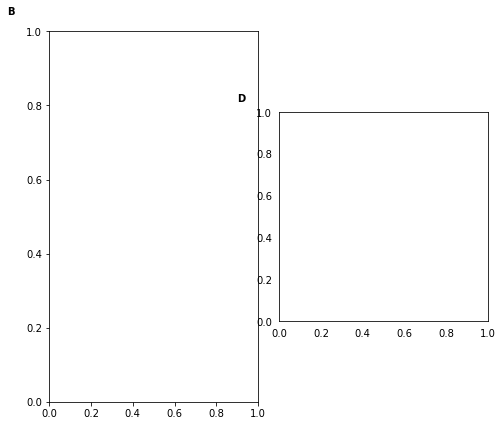

In [12]:
# %%capture captured
from M2E_visualize_interareal_connectivity import visualize_interareal_connectivity
visualize_interareal_connectivity(M)

Full-scale interareal connectivity is from: <br>
Schmidt M, Bakker R, Hilgetag CC, Diesmann M & van Albada SJ <br>
Multi-scale account of the network structure of macaque visual cortex <br>
Brain Structure and Function (2018), 223: 1409 [https://doi.org/10.1007/s00429-017-1554-4](https://doi.org/10.1007/s00429-017-1554-4) <br> 
Fig 4. D **Area-level connectivity of the model, based on data in a–c, expressed as relative indegrees for each target area**

Go back to [Notebook structure](#toc)

### 2.4. Run a simulation <a class="anchor" id="section_2_4"></a>

In [ ]:
%%capture captured
# run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.
M.simulation.simulate()

Go back to [Notebook structure](#toc)

## S3. Simulation Results Visualziation <a class="anchor" id="section_3"></a>

In [ ]:
# Instantiate an analysis class and load spike data
A = Analysis(network=M, 
             simulation=M.simulation, 
             data_list=['spikes'],
             load_areas=None)

### 3.1. Instantaneous and mean firing rate across all populations <a class="anchor" id="section_3_1"></a>

In [ ]:
from M2E_visualize_instantaneous_and_mean_firing_rates import plot_instan_mean_firing_rate
plot_instan_mean_firing_rate(M)

### 3.2 Resting state plots <a class="anchor" id="section_3_2"></a>

**Fig 5. Resting state of the model with χ =1.9.** (A-C) Raster plot of spiking activity of 3% of the neurons in area V1 (A), V2 (B), and FEF (C). Blue: excitatory neurons, red: inhibitory neurons. (D-F) Spiking statistics across all 32 areas for the respective populations shown as area-averaged box plots. Crosses: medians, boxes: interquartile range (IQR), whiskers extend to the most extremeobservat ions within 1.5×IQR beyond the IQR. (D) Population-averaged firing rates. (E) Average pairwise correlation coefficients of spiking activity. (F) Irregularity measured by revised local variation LvR averaged across neurons. (G) Area-averaged firing rates, shown as raw binned spike histograms with 1ms bin width (gray) and convolved histograms, with aGaussian kernel (black) of optimal width.

In [ ]:
from M2E_visualize_resting_state import plot_resting_state
plot_resting_state(M, A, data_path)

### 3.3 Time-averaged population rates <a class="anchor" id="section_4_3"></a>
An overview over time-averaged population rates encoded in colors with areas along x-axis and populations along y-axis.

In [ ]:
# %%capture captured
A.show_rates()

|Area index|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|
|:--------:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Area      |V1|V2|VP|V3|PIP|V3A|MT|V4t|V4|PO|VOT|DP|MIP|MDP|MSTd|VIP|LIP|PITv|PITd|AITv|MSTl|FST|CITv|CITd|7a|STPp|STPa|FEF|46|TF|TH|AITd| 

Go back to [Notebook structure](#toc)